### Confirm that windfarms are properly removed

KDOX20100914_103552_V04
/scratch2/wenlongzhao/roosts/libs/wsrdata/tools/../static/arrays/v0.1.0


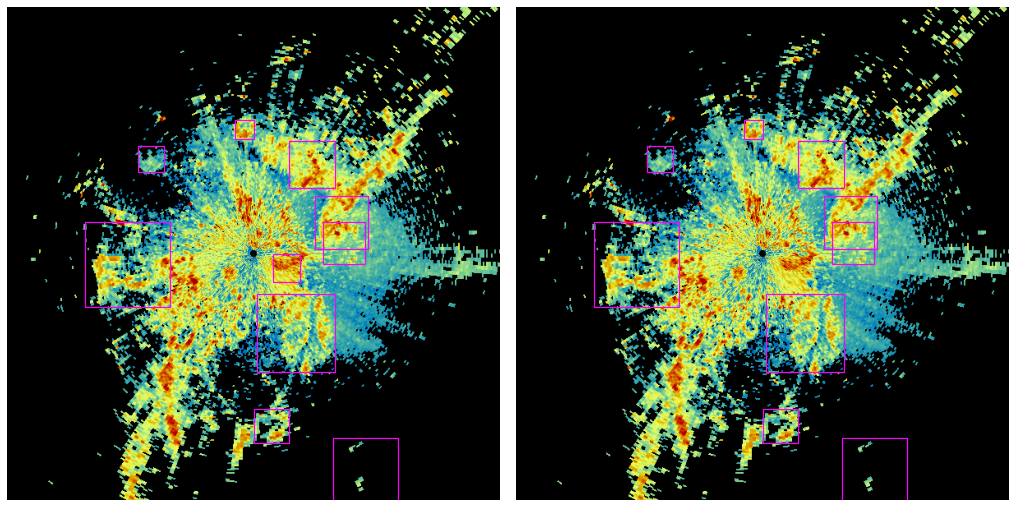

In [31]:
import os
import numpy as np
import json
from wsrlib import pyart, radar2mat
from wsrdata.utils.bbox_utils import scale_XYWH_box
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

NORMALIZERS = {
        'reflectivity':              pltc.Normalize(vmin=  -5, vmax= 35),
        'velocity':                  pltc.Normalize(vmin= -15, vmax= 15),
        'spectrum_width':            pltc.Normalize(vmin=   0, vmax= 10),
        'differential_reflectivity': pltc.Normalize(vmin=  -4, vmax= 8),
        'differential_phase':        pltc.Normalize(vmin=   0, vmax= 250),
        'cross_correlation_ratio':   pltc.Normalize(vmin=   0, vmax= 1.1)
}

SCANNAME = "KDOX20100914_103552_V04"
print(SCANNAME)
STATION_DAY = SCANNAME[:12]
ATTR = "reflectivity"

JSON_PATH = "/scratch2/wenlongzhao/roosts/libs/wsrdata/datasets/roosts_v0.1.0/roosts_v0.1.0.json"
with open(JSON_PATH, "r") as f:
    dataset = json.load(f)
    print(dataset["info"]["array_dir"])
scan_to_id = {}
for scan in dataset["scans"]:
    scan_to_id[scan["key"]] = scan["id"]

scan = dataset["scans"][scan_to_id[SCANNAME]]
array = np.load(os.path.join(dataset["info"]["array_dir"], scan["array_path"]))["array"]

fig, axs = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

detections = wf_cleaned_detections[STATION_DAY]
for i in range(2):
    subplt = axs[i]
    subplt.axis('off')
    cm = plt.get_cmap(pyart.config.get_field_colormap(ATTR))
    rgb = cm(NORMALIZERS[ATTR](array[0, 0, :, :]))
    rgb = rgb[:, :, :3] # omit the fourth alpha dimension, NAN are black but not white
    subplt.imshow(rgb, origin='lower') # set the origin to lower so that north is the top of the image
    for detection in detections:
        if detection["scanname"] == SCANNAME and (i==0 or (i==1 and not detection["windfarm"])): # and detection["det_score"] != -1 
            bbox =  [
                detection["im_bbox"][0]-detection["im_bbox"][2],
                image_height-detection["im_bbox"][1]-detection["im_bbox"][2],
                detection["im_bbox"][2]*2, detection["im_bbox"][2]*2,
            ]
            subplt.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='#FF00FF', linewidth=1.2))

plt.show()
plt.close(fig)

In [36]:
import csv
from geopy import distance
SCANNAME = "KDOX20100914_103552_V04"
STATION_DAY = SCANNAME[:12]
detections = wf_cleaned_detections[STATION_DAY]
for detection in detections:
    if detection["scanname"] == SCANNAME and detection["windfarm"]:
        print(detection)
        break

with open("/scratch2/wenlongzhao/roost-system/src/roosts/utils/uswtdb_v1_3_20190107.csv", 'r') as f:
    reader = csv.reader(f)
    wind_farm_list = list(reader)

x = 18.355/2
y = 39.569/2
for entity in wind_farm_list[1:]:
    lon = float(entity[-2])
    lat = float(entity[-1])
    if distance.distance((detection["geo_bbox"][1], detection["geo_bbox"][0]), (lat,lon)).km < np.sqrt(x**2+y**2):
        print(entity)

{'scanname': 'KDOX20100914_103552_V04', 'det_ID': 2640, 'det_score': 0.056708283722400665, 'im_bbox': array([339.56900024, 318.35534668,  16.85110474]), 'track_ID': 17, 'track_NMS': False, 'geo_bbox': [-75.21243305047484, 38.74266496034587, 8425.552368164062], 'from_sunrise': -7.0, 'rain': False, 'windfarm': True}
['3029663', '10-020303', '2009-WTE-10287-OE', '18031', 'DE', 'Sussex County', '10005', 'University of Delaware', '2010', '1', '2', 'Gamesa', 'G90-2.0', '2000', '78', '90', '6361.73', '123.1', '3', '3', '', 'Bing Maps Aerial', '-75.164902', '38.782890']


### Confirm that dualpol can help with removing rain false positives

In [6]:
import os
import numpy as np
import json
from wsrlib import pyart, radar2mat
from wsrdata.utils.bbox_utils import scale_XYWH_box
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as pltc

NORMALIZERS = {
        'reflectivity':              pltc.Normalize(vmin=  -5, vmax= 35),
        'velocity':                  pltc.Normalize(vmin= -15, vmax= 15),
        'spectrum_width':            pltc.Normalize(vmin=   0, vmax= 10),
        'differential_reflectivity': pltc.Normalize(vmin=  -4, vmax= 8),
        'differential_phase':        pltc.Normalize(vmin=   0, vmax= 250),
        'cross_correlation_ratio':   pltc.Normalize(vmin=   0, vmax= 1.1)
}

ARRAY_Y_DIRECTION   = "xy" # default radar direction, y is first dim (row), large y is north, row 0 is south
ARRAY_R_MAX         = 150000.0
ARRAY_DIM           = 600
ARRAY_ATTRIBUTES    = ["reflectivity", "velocity", "spectrum_width"]
ARRAY_ELEVATIONS    = [0.5, 1.5, 2.5, 3.5, 4.5]
ARRAY_RENDER_CONFIG = {"ydirection":          ARRAY_Y_DIRECTION,
                       "fields":              ARRAY_ATTRIBUTES,
                       "coords":              "cartesian",
                       "r_min":               2125.0,       # default: first range bin of WSR-88D
                       "r_max":               ARRAY_R_MAX,  # 459875.0 default: last range bin
                       "r_res":               250,          # default: super-res gate spacing
                       "az_res":              0.5,          # default: super-res azimuth resolution
                       "dim":                 ARRAY_DIM,    # num pixels on a side in Cartesian rendering
                       "sweeps":              None,
                       "elevs":               ARRAY_ELEVATIONS,
                       "use_ground_range":    True,
                       "interp_method":       'nearest'}
DUALPOL_DIM             = 600
DUALPOL_ATTRIBUTES      = ["differential_reflectivity", "cross_correlation_ratio", "differential_phase"]
DUALPOL_ELEVATIONS      = [0.5, 1.5, 2.5, 3.5, 4.5]
DUALPOL_RENDER_CONFIG   = {"ydirection":          ARRAY_Y_DIRECTION,
                           "fields":              DUALPOL_ATTRIBUTES,
                           "coords":              "cartesian",
                           "r_min":               2125.0,       # default: first range bin of WSR-88D
                           "r_max":               ARRAY_R_MAX,  # default 459875.0: last range bin
                           "r_res":               250,          # default: super-res gate spacing
                           "az_res":              0.5,          # default: super-res azimuth resolution
                           "dim":                 DUALPOL_DIM,  # num pixels on a side in Cartesian rendering
                           "sweeps":              None,
                           "elevs":               DUALPOL_ELEVATIONS,
                           "use_ground_range":    True,
                           "interp_method":       "nearest"}

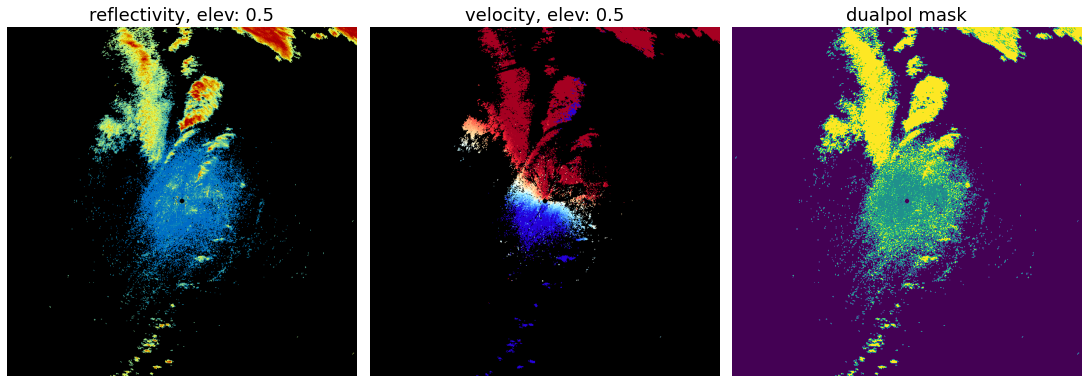

In [14]:
# Download a scan, pick channels, render and visualize arrays

from wsrdata.utils.s3_utils import download_scans

OUTPUT_DIR = "tmp"
KEY = "2020/06/10/KAPX/KAPX20200610_092646_V06"
ATTRIBUTES = ["reflectivity", "velocity"]
ELEVATIONS = [0.5]

os.makedirs(OUTPUT_DIR, exist_ok=True)
download_scans([KEY], OUTPUT_DIR)
radar = pyart.io.read_nexrad_archive(os.path.join(OUTPUT_DIR, KEY))
data, fields, elevs, y, x = radar2mat(radar,**ARRAY_RENDER_CONFIG)

fig, axs = plt.subplots(len(ELEVATIONS), len(ATTRIBUTES)+1, figsize=(7*len(ATTRIBUTES)+1, 7*len(ELEVATIONS)), constrained_layout=True)

for i, attr in enumerate(ATTRIBUTES):
    for j, elev in enumerate(ELEVATIONS):
        if len(ATTRIBUTES) > 1 and len(ELEVATIONS) > 1:
            subplt = axs[j, i]
        elif len(ATTRIBUTES) > 1:
            subplt = axs[i]
        else:
            subplt = axs[j]
        subplt.axis('off')
        subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
        cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
        rgb = cm(NORMALIZERS[attr](data[i, j, :, :]))[:, :, :3] # omit the fourth alpha dimension
        subplt.imshow(rgb, origin='lower') # set the origin to lower so that north is the top of the image

data, fields, elevs, y, x = radar2mat(radar,**DUALPOL_RENDER_CONFIG)
dualpol = data[1, 0, ::-1, :]

dualpol_threshold = 0.95
NAN, BIRD, RAIN = 1, 2, 3

dualpol_pred = BIRD * np.ones(dualpol.shape)  # 2: bird
dualpol_pred[np.isnan(dualpol)] = NAN # 1: nan
# make area with nan value smaller than dualpol_threshold
dualpol[np.isnan(dualpol)] = dualpol_threshold - 1 
dualpol_pred[dualpol > dualpol_threshold] = RAIN # 3: rain
subplt = axs[2]
subplt.axis('off')
subplt.set_title("dualpol mask", fontsize=18)
subplt.imshow(dualpol_pred)

plt.show()
plt.close(fig)